# First attempt at humpback whale classification

Here is my attempt to apply learning of fastai v3 course at humpback whale competition. Along with that i am borrowing codes from 'https://github.com/radekosmulski/whale/'. Big thanks to him for creating such an awesome repository to get a good starting point at this competition

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
#from skimage.util import montage
import pandas as pd
from torch import optim
import re


import numpy as np
import torch
import pandas as pd
import os 
import sys
from utils import *

In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
def top_5_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    for i in range(top_5.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_5[i]]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'data/whale/subs/{name}.csv' , index = False)
    #sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')
                                                                        


In [4]:
df = pd.read_csv('data/whale/train.csv')
freq_whale_ids = df.Id.value_counts().reset_index()

In [5]:
print(100*round(freq_whale_ids[freq_whale_ids['index']=='new_whale']['Id'].values[0]/freq_whale_ids['Id'].sum(),4) ,'% of whales in training data are un-recognized ones (new_whale)' )


38.11 % of whales in training data are un-recognized ones (new_whale)


Because almost 38% of data is from  un-recognised category , we can remove that data from modelling. We will first train a CNN classifier on only images with recognised categories. 

In [6]:
## subset of data after removing new whale category
freq_whale_ids2 = freq_whale_ids[freq_whale_ids['index']!='new_whale']

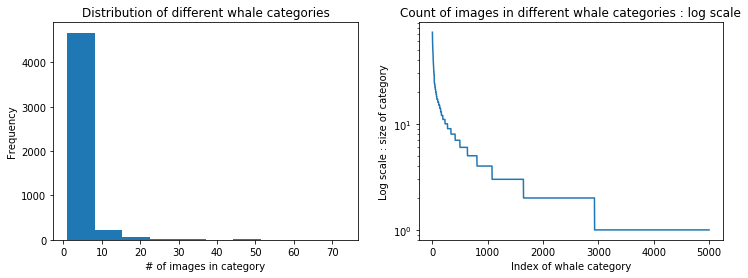

In [7]:
plt.figure(figsize=(12 ,4))
plt.subplot(121)
_, _,_ = plt.hist(freq_whale_ids2['Id'].values)
plt.xlabel('# of images in category')
plt.ylabel('Frequency')
plt.title('Distribution of different whale categories')

plt.subplot(122)
_ = plt.plot(freq_whale_ids2['Id'].values)
plt.xlabel('Index of whale category')
plt.ylabel('Log scale : size of category')
plt.title('Count of images in different whale categories : log scale')
plt.gca().set_yscale('log')

We can see from the histogram plot that most of the categories (around 5000) have around 8 images in training data. Let us look at exact percentages

In [8]:
print(round((freq_whale_ids[freq_whale_ids['Id']==1]['Id'].values.sum())/(freq_whale_ids['index'].nunique())*100,2) , '% of whale categories have just 1 image in training data')
print(round((freq_whale_ids[freq_whale_ids['Id']<=10]['index'].nunique())/(freq_whale_ids['index'].nunique())*100,2) , '% of whale categories have less than 10 images in training data')

41.42 % of whale categories have just 1 image in training data
95.44 % of whale categories have less than 10 images in training data


Let us try a resnet 50 classifier on the data sets , we will create validation data split according to some function

In [14]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)


## For categories having at least 2 images we will put one image in validation data

In [9]:
freq_whale_ids.rename(columns={'index': 'Id' , 'Id':'count'} , inplace = True)
val_set_freq = freq_whale_ids[(freq_whale_ids['count']>1)]
df_count = df.merge(val_set_freq , how = 'inner' , on = ['Id'])


In [10]:
val_idxs = set(df_count.groupby('Id').first()['Image'].values)
print('Size of validationd data set' , len(val_idxs))

Size of validationd data set 2932


In [11]:
name = f'res50-first-submission'

In [12]:
SZ = 64
BS = 64
NUM_WORKERS = 12
SEED = 0

In [15]:
data = (
    ImageItemList
        .from_df(df ,'data/whale/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_idxs)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/whale/test'))
        .transform(get_transforms(do_flip=False , max_rotate = 2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [16]:
learn = create_cnn(data , models.resnet18)
learn.fit_one_cycle(2)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/FRACTAL/jitesh.arora/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:05<00:00, 9230265.11it/s] 


epoch     train_loss  valid_loss
1         5.620665    9.347747    
2         5.225325    9.499393    


epoch     train_loss  valid_loss
1         20.128336               
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


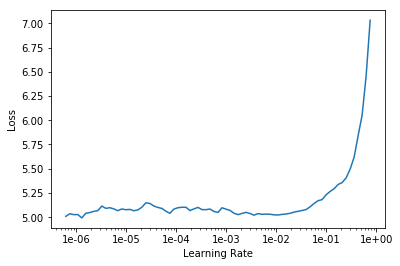

In [17]:
learn.lr_find()
learn.recorder.plot()

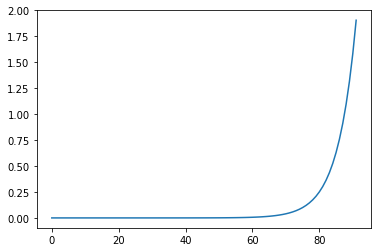

In [19]:
learn.recorder.plot_lr()

In [20]:
max_lr = 1e-4
lrs = [max_lr/100 , max_lr/10 , max_lr]

In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, lrs)

epoch     train_loss  valid_loss
1         5.058058    9.442575    
2         5.063495    9.467267    
3         4.854183    9.424864    
4         4.933847    9.365927    
5         4.894750    9.367785    


In [22]:
learn.fit_one_cycle(24 , lrs)
learn.save(f'{name}-stage-2')


epoch     train_loss  valid_loss
1         4.799887    9.397250    
2         4.743395    9.365311    
3         4.826654    9.352144    
4         4.828978    9.259808    
5         4.800480    9.230893    
6         4.681401    9.243524    
7         4.696200    9.174604    
8         4.516544    9.139720    
9         4.592390    9.061385    
10        4.558135    9.099194    
11        4.481848    9.054968    
12        4.337978    9.013273    
13        4.439382    8.987525    
14        4.309020    8.992174    
15        4.263684    8.978573    
16        4.201837    9.007794    
17        4.179200    8.988955    
18        4.181356    8.902350    
19        4.202553    8.954312    
20        4.201358    8.956646    
21        4.113857    8.925042    
22        4.278600    9.012268    
23        4.099959    8.907429    
24        4.029446    8.866950    


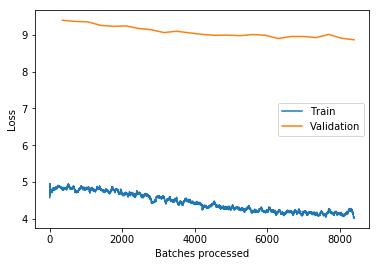

In [23]:
learn.recorder.plot_losses()

In [34]:
preds, _ = learn.get_preds(DatasetType.Test)
#preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [35]:
classes = learn.data.classes

In [36]:
name = 'whale_first_submission_classifier'
create_submission(preds, learn.data, name, classes)